### Introduction


In [12]:
import gym
import sys
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy
from tqdm import tqdm

In [2]:
env = gym.make('Blackjack-v0')

/Users/solkim/opt/anaconda3/envs/rl/lib/python3.8/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [4]:
print(np.arange(2))

[0 1]


In [5]:
for i_episode in range(10):
    print("GAME START>>>\n")
    state = env.reset()
    while True:
        print("NEXT>>>\n")
        print("current state :",state)
        action = env.action_space.sample()
        print("my action :",action)
        state, reward, done, info = env.step(action)
        print("SOOO,\nnext state : ",state)
        print("reward:",reward)
        print("done? : ",done)
        print("info",info)
        if done:
            print('End game! Reward: ', reward)
            if reward>0:
                print('You won :)\n') 
            elif reward<0: 
                print('You lost :(\n') 
            else :
                print('You draw :|\n')
            break

GAME START>>>

NEXT>>>

current state : (10, 6, False)
my action : 0
SOOO,
next state :  (10, 6, False)
reward: 1.0
done? :  True
info {}
End game! Reward:  1.0
You won :)

GAME START>>>

NEXT>>>

current state : (11, 1, False)
my action : 1
SOOO,
next state :  (16, 1, False)
reward: 0
done? :  False
info {}
NEXT>>>

current state : (16, 1, False)
my action : 1
SOOO,
next state :  (23, 1, False)
reward: -1
done? :  True
info {}
End game! Reward:  -1
You lost :(

GAME START>>>

NEXT>>>

current state : (17, 1, True)
my action : 0
SOOO,
next state :  (17, 1, True)
reward: -1.0
done? :  True
info {}
End game! Reward:  -1.0
You lost :(

GAME START>>>

NEXT>>>

current state : (6, 7, False)
my action : 1
SOOO,
next state :  (13, 7, False)
reward: 0
done? :  False
info {}
NEXT>>>

current state : (13, 7, False)
my action : 1
SOOO,
next state :  (23, 7, False)
reward: -1
done? :  True
info {}
End game! Reward:  -1
You lost :(

GAME START>>>

NEXT>>>

current state : (15, 10, False)
my action 

### Problem 1: MC Prediction

In [6]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [7]:
for i in range(10): # 경험 누적하기
    ep = generate_episode_from_limit_stochastic(env)
    print(ep)
    s,a,r = zip(*ep)
    print(s,a,r)
    print(len(ep),'\n')

[((13, 10, False), 1, -1)]
((13, 10, False),) (1,) (-1,)
1 

[((12, 1, False), 1, 0), ((18, 1, False), 0, 1.0)]
((12, 1, False), (18, 1, False)) (1, 0) (0, 1.0)
2 

[((17, 1, False), 1, -1)]
((17, 1, False),) (1,) (-1,)
1 

[((14, 10, False), 1, -1)]
((14, 10, False),) (1,) (-1,)
1 

[((20, 4, False), 0, 1.0)]
((20, 4, False),) (0,) (1.0,)
1 

[((15, 4, False), 1, -1)]
((15, 4, False),) (1,) (-1,)
1 

[((20, 4, True), 0, 1.0)]
((20, 4, True),) (0,) (1.0,)
1 

[((15, 1, False), 1, 0), ((16, 1, False), 0, -1.0)]
((15, 1, False), (16, 1, False)) (1, 0) (0, -1.0)
2 

[((6, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
((6, 10, False), (16, 10, False)) (1, 0) (0, -1.0)
2 

[((17, 10, False), 1, -1)]
((17, 10, False),) (1,) (-1,)
1 



In [14]:
def mc_prediction_q_first_(env, num_episodes, generate_episode, gamma=1.0):
    # Initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        print("\n>>this episode : ",episode)
        print("discounts : ", discounts)
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            print("i : ",i,"/ state : ",state)
            print("reward:",rewards[i:],"/ discount:",discounts[:-(1+i)])
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [9]:
def mc_prediction_q_every(env, num_episodes, generate_episode, gamma=1.0):
    # Initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for i_episode in tqdm(range(1, num_episodes+1)):
        ep = generate_episode(env)
        T = len(ep)
        
        for t in range(T-1):
            St = ep[t][0]; At = ep[t][1]; Rt = ep[t][2]
            # discounts = np.array([gamma**i for i in range(len(Rt)+1)])
            if t==0:
                N[St][At] += 1
                returns_sum[St][At] += sum(Rt[i:])
                Q[St][At] = returns_sum[St][At]/N[St][At]

    return Q


>>this episode :  [((6, 8, False), 1, 0), ((9, 8, False), 1, 0), ((16, 8, False), 1, 0), ((17, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
discounts :  [1. 1. 1. 1. 1. 1.]
i :  0 / state :  (6, 8, False)
reward: (0, 0, 0, 0, 1.0) / discount: [1. 1. 1. 1. 1.]
i :  1 / state :  (9, 8, False)
reward: (0, 0, 0, 1.0) / discount: [1. 1. 1. 1.]
i :  2 / state :  (16, 8, False)
reward: (0, 0, 1.0) / discount: [1. 1. 1.]
i :  3 / state :  (17, 8, False)
reward: (0, 1.0) / discount: [1. 1.]
i :  4 / state :  (20, 8, False)
reward: (1.0,) / discount: [1.]

>>this episode :  [((12, 7, False), 1, -1)]
discounts :  [1. 1.]
i :  0 / state :  (12, 7, False)
reward: (-1,) / discount: [1.]

>>this episode :  [((20, 10, True), 0, 1.0)]
discounts :  [1. 1.]
i :  0 / state :  (20, 10, True)
reward: (1.0,) / discount: [1.]

>>this episode :  [((14, 5, False), 1, -1)]
discounts :  [1. 1.]
i :  0 / state :  (14, 5, False)
reward: (-1,) / discount: [1.]

>>this episode :  [((16, 2, True), 1, 0), ((17, 2, True

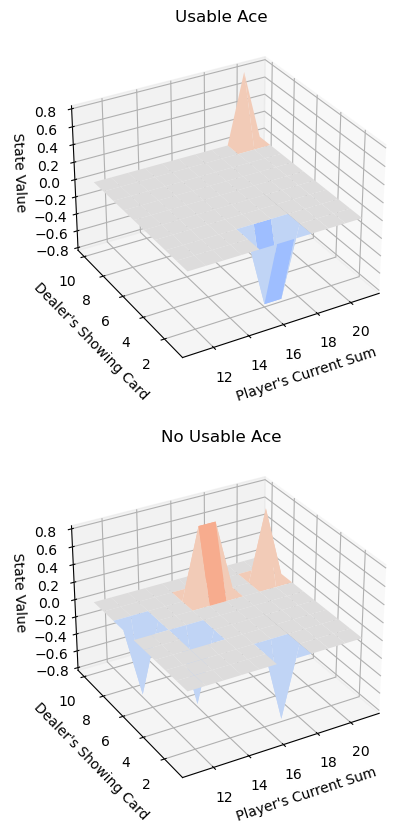

In [17]:


Q = mc_prediction_q_first_(env, 5, generate_episode_from_limit_stochastic)
print("* Q.items() : ",Q.items())
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())
plot_blackjack_values(V_to_plot)

### Problem 2: MC Control

In [18]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [19]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in tqdm(range(1, num_episodes+1)):
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
        policy = dict((k,np.argmax(v)) for k, v in Q.items())

    return policy, Q

In [20]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.02)

100%|██████████| 500000/500000 [07:18<00:00, 1140.18it/s]


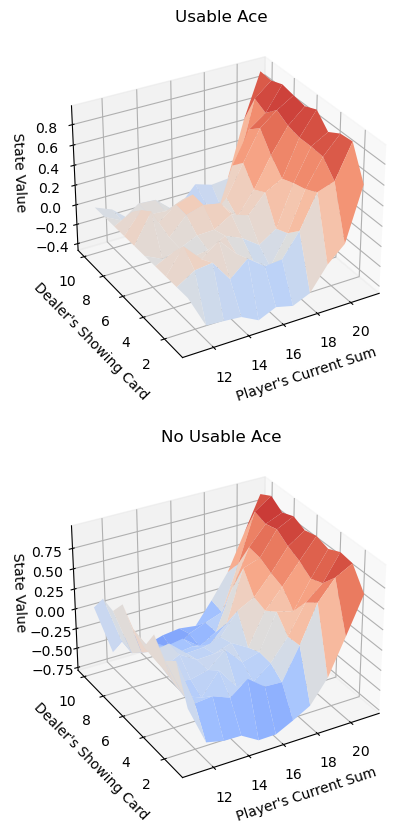

In [21]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

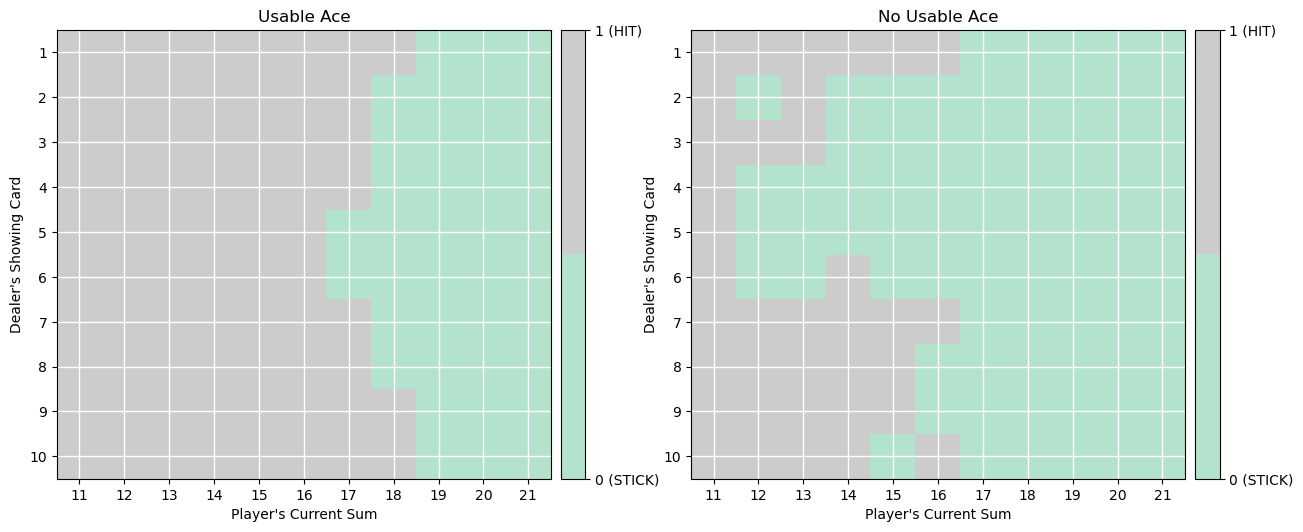

In [22]:
plot_policy(policy)